# ASTR4004 Assignment 4 - Neural Networks

Design a neural network for regression (*bonus points if the model is astrophysical*)
- with at least 5 neurons;
- either involving relu ($\verb|max(0,x)|$) or sigmoid ($1/\exp(-x)+1$) activation functions; 
- having a loss that within 10 steps:
    - montonically decreases when the learning rate is $0.1$
    - but can incrase within 10 steps when the learning rate is $>0.1$ 

The report should include
- a description of the model or regression probelem you are solving; ($10\%$);
- a graph illustrating the network structure; ($10\%$);
- equations of gradient for all neurons; ($30\%$);
- two tables listing weights, gradietns, outputs and loss for 10 steps
    - learning rates = $0.1$, ($25\%$);
    - learning rates > $0.1$, ($25\%$);

In [2]:
## set up pkgs 

import numpy as np
import matplotlib.pyplot as plt
import astropy.constants as c 
import astropy.units as u 
import os 
import glob
import pandas as pd 
import smplotlib


## get directories
data_dir = 'data'
fig_dir = 'figures'

## Question 1 

*First define the regression problem you're solving. For example, this could involve fitting data points or using an astrophysical model to predict the CMB optical depth based on the neutral fraction of the intergalactic medium. Essentially, you'll need to specify some input data points - typically a set of $x$ values and their corresponding outputs $y$. In the lecture example, $x=1$ and $y=1$, meaning the task was to map the input exactly to itself, i.e. $y=x$. This part accounts for $10\%$ of the total score for Assignment 4.*

### Answer


**Answer**: Let's use data from a real astrophysical scenario. My research investigates the relationship between $\alpha \equiv M_\mathrm{Dyn}/M_\mathrm{SPS}$ where and $\sigma_e$ where $M_\mathrm{Dyn}$ is the dynamical mass of a galaxy, $M_\mathrm{SPS}$ is the stellar mass from SED fitting and $\sigma_e$ is the central velocity dispersion. The parameter $\alpha$, is then the so-called 'IMF mismatch parameter', the ratio between the dynamical and stellar masses. For quiescent galaxies at high-$z$, we expect $\alpha \approx 1$ if the IMF is chosen correctly, yet observational data suggests this is not the case rather lots of galaxies at $z \sim 2$ find $\alpha < 1$. 

To obtain an accurate measure of the dynamical mass of a galaxy, one must be able to model the surface brightness profile as a means of inferring the stellar surface density. This is crucial to solve the Jeans equations by which one may obtain a dynamical mass estimate. A fundamental parameter in the modelling the surface brightness is the half-light size or effective radius $r_\mathrm{eff}.$ In my research I am fortunate enough to use measurements from the new JWST telescope and so an interesting point of discussion involves a comparison of the sizes of galaxies measured using JWST and HST. For the neural network described in this assignment, we will attempt to fit a linear relationship to this comparison from my Honours research. 

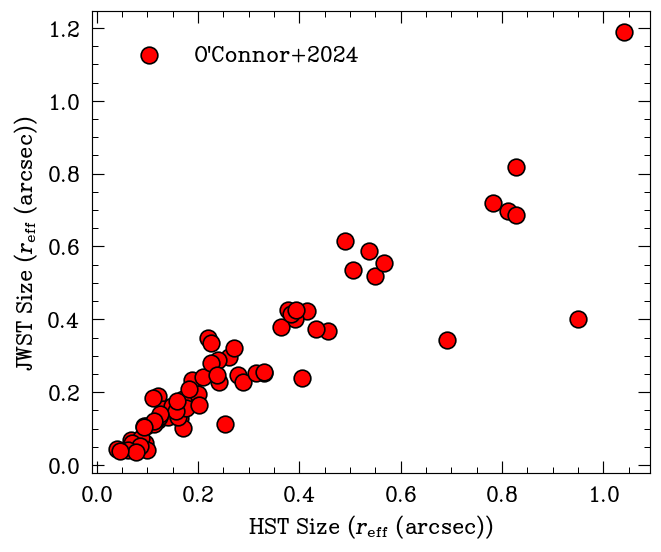

In [3]:
## load in the data
oconnor_2024 = pd.read_csv(os.path.join(data_dir, 'hst_jwst_data.csv'))
hst_size = oconnor_2024['HST_reff']
jwst_size = oconnor_2024['JWST_reff_size']

## plot the data
fig, ax = plt.subplots(figsize = (6,5))

ax.scatter(hst_size, jwst_size, s=100, edgecolor='black', color='red', label="O'Connor+2024")

ax.set_xlabel(r'HST Size ($r_\mathrm{eff}$ (arcsec))')
ax.set_ylabel(r'JWST Size ($r_\mathrm{eff}$ (arcsec))')

ax.legend(loc='upper left')

plt.savefig(os.path.join(fig_dir, "data_to_fit.pdf"))


## Question 2

*Next, outline your network architecture, including a schematic that shows how the neurons are distributed and connected. Remember, you need at least 5 neurons. This section is worth $10\%$.*


**Answer:** Let's now define the architecture for our neural network. We will use a feed-foraward neural network (FFN) with the following structure:

 - **Input Layer:** Takes in the $x_i$ data points, array of shape $i$.
 - **Hidden Layer:** with $k$ neurons, connected to the inputs. We will use a ReLU activation function. This is denoted layer $M=0$.
 - **Output Layer:** Outputs a single value for the regression model; we will also use a ReLU activation function, and this layer is denoted $M=1$.



Let’s expand on this: In terms of notation, we denote the layer by the superscript $M$ where $M=0$ is the hidden layer and $1$ is the output layer.  

**Step 1:** The input layer is the data points along $x$. In this case, the data points are represented by $x_i$. 

**Step 2:** The $k$ neurons in the hidden layer take the inputs $x_i$ and compute a weighted sum over weights $w_k^{(0)}$ with the addition of a bias $b_k^{(0)}$ such that 
\begin{equation}
    z^{(0)}_k = w_k^{(0)} x_i + b_k^{(0)}
\end{equation}

Or in vector notation,
\begin{equation}
    \mathbf{Z}^{(0)} = x_i \mathbf{W}^{(0)} + \mathbf{B}^{(0)}
\end{equation}

where the weights $\mathbf{W}^{(0)}$ and $\mathbf{B}^{(0)}$ have shapes $k \times 1$. The activation function then acts on $z_k$, in this case the ReLU function, which gives the activation $a_k^{(0)} = \mathrm{ReLU}(z_k^{(0)})$. Or again in vector notation, we arrive at the activation $\mathbf{A}^{(0)}$.  

**Step 3:** The activations $a_k^{(0)}$ of the hidden layer then act as the inputs to the output layer such that
\begin{equation}
    z^{(1)} = w_{j}^{(1)} a_k^{(0)} + b^{(1)}
\end{equation}

and therefore the activation for this layer is $y^{(1)} = \sigma\left(z^{(1)}\right)$. In vector notation we find
\begin{equation}
    z^{(1)} = \mathbf{W}^{(1)} \mathbf{A}^{(0)} + b^{(1)}
\end{equation}

where the matrix $\mathbf{W}^{(1)}$ has shape $1 \times k$ and $\mathbf{A}^{(0)}$ has shape $k \times 1$. The predicted value $y^{(1)}$ is then given by the activation of the output layer $y^{(1)} = a^{(1)} = \mathrm{ReLU}(z^{(1)}).$

## Question 3

*The third step is to derive the gradient for all neurons, specifically $dL/dw_i$ and $dL/db_i$. This step is worth $30\%$. Be sure to apply the chain rule and keep in mind that your neurons may have multiple inputs, unlike the simpler example provided in the lecture.*

**Answer**: We now wish to define the gradients for all neurons using the loss function which his the mean squared error (MSE) $L=0.5(\hat{y}-y)^2$ where $\hat{y}$ is the predicted value from the neural network and $y$ is the true value. 

We first compute the gradient of the loss function with respect to the weights connecting the hidden layer to the output layer
\begin{equation}
    \frac{\partial L}{\partial w_j^{(1)}} = \frac{\partial L}{\partial y^{(1)}}\frac{\partial y^{(1)}}{\partial z^{(1)}}\frac{\partial z^{(1)}}{\partial w_j^{(1)}} = (y^{(1)}-y) \cdot a^{(0)}_k
\end{equation}

since $\partial y^{(1)}/\partial z^{(1)} = 1$ for the $\mathrm{ReLU}(z)$ function where $z \geq 0.$ Then, the gradient of the loss function with respect to the bias connecting the hidden layer to the output layer
\begin{equation}
    \frac{\partial L}{\partial b^{(1)}} = \frac{\partial L}{\partial y^{(1)}}\frac{\partial y^{(1)}}{\partial z^{(1)}}\frac{\partial z^{(1)}}{\partial b^{(1)}} = (y^{(1)}-y).
\end{equation}

Now let's compute the gradient of the loss function with respect to the weights connecting the input layer to the hidden layer
\begin{equation}
    \frac{\partial L}{\partial w_{k}^{(0)}} = \frac{\partial L}{\partial y^{(1)}} \frac{\partial y^{(1)}}{\partial z^{(1)}} \frac{\partial z^{(1)}}{\partial a_k^{(0)}} \frac{\partial a_k^{(0)}}{\partial z_k^{(0)}} \frac{\partial z_k^{(0)}}{\partial w_k^{(0)}} = (y^{(1)}-y) \cdot w_j^{(1)} \cdot x_i
\end{equation}

and with respect to the bias
\begin{equation}
    \frac{\partial L}{\partial b_{k}^{(0)}} = \frac{\partial L}{\partial y^{(1)}} \frac{\partial y^{(1)}}{\partial z^{(1)}} \frac{\partial z^{(1)}}{\partial a_k^{(0)}} \frac{\partial a_k^{(0)}}{\partial z_k^{(0)}} \frac{\partial z_k^{(0)}}{\partial b_k^{(0)}} = (y^{(1)}-y) \cdot w_j^{(1)} .
\end{equation}

Additionally, for computational efficiency and to ensure the gradients do not become exceptionally large leading to an unstable network, we divide the gradients by $m$ where $m$ is the number of data points. In this way, the gradient is an average gradient for the training data.

## Question 4

*In the fourth step, show the training process in action by listing the weights, biases, gradients, outputs, and loss over $10$ steps. You should observe the loss decreasing montonically if you set the learning rate to a small value, such as $0.1$. This part is worth $25\%$.*

In [88]:
## let's now create the neural network

class FFN_line_fit:
    """ 
    Simple FFN to fit lines to data points
    """

    def __init__(self, input_size, hidden_size, output_size, learning_rate=0.1):
        """
        Initialise a FFN neural network with weights and biases

        Parameters:
        -----------
        input_size: int
            number of input features
        hidden_size: int
            number of neurons in hidden layer
        output_size: int
            number of output neurons
        learning_rate: float
            learning rate for weight updates
        """

        # initalise weights and biases
        self.W0 = np.random.rand(hidden_size, input_size) # weights for input to hidden layer M=0
        self.B0 = np.zeros((hidden_size,1)) # biases for hidden layer M=0
        self.W1 = np.random.rand(output_size, hidden_size) # weights for hidden layer M=0 to output layer M=1
        self.B1 = np.zeros((output_size,1)) # biases for output layer M=1

        self.learning_rate = learning_rate 

        # store history
        self.history = {
            'weights_W0': [],
            'biases_B0': [],
            'weights_W1': [],
            'biases_B1': [],
            'A0': [],
            'Y1': [],
            'dLdW0': [],
            'dLdB0': [],
            'dLdW1': [],
            'dLdB1': [],
            'loss': []
        }
        
    # define the sigmoid function
    def sigmoid(self, z):
        return 1/(1+np.exp(-z))

    # define the derivative of the sigmoid function
    def dsigmoid(self, a):
        return a*(1-a)
    
    # define the ReLU function
    def relu(self, z):
        return np.maximum(0, z)

    # define the ReLU derivative
    def drelu(self, z):
        return np.where(z > 0, 1, 0)

    # define the forward pass through the neural network
    def forward_pass(self, x):
        """ 
        Define and perform the forward pass through the FFN.

        Parameters:
        -----------
        x: arr_like
            input data of shape (input_size, number_of_data_points)

        Returns:
        --------
        Y1: arr_like
            predicted output of FFN of shape (output_size, number_of_data_points)
        """

        self.Z0 = np.dot(self.W0, x) + self.B0 # weighted sum of hidden layer
        self.A0 = self.relu(self.Z0) # activation of hidden layer
        self.Z1 = np.dot(self.W1, self.A0) + self.B1 # weighted sum of output layer
        self.Y1 = self.relu(self.Z1) # activation of output layer
        return self.Y1
    
    # compute the loss function
    def loss(self, y_true, Y1):
        """ 
        Compute the MSE loss.

        Parameters:
        -----------
        y_true: arr_like 
            true output value of shape (output_size, number_of_data_points)
        Y1: arr_like 
            predicted output from FFN of shape (output_size, number_of_data_points)
        """

        return np.mean(0.5*(Y1 - y_true)**2)
    
    # define the backpropagation 
    def backpropagate(self, x, y_true):
        """ 
        Perform backpropagation to calculate and update weights and biases.

        Parameters:
        -----------
        x:  arr_like 
            input data of shape (input_size, number_of_data_points)
        y_true: arr_like 
            true output value of shape (output_size, number_of_data_points)
        """

        m = y_true.shape[1]

        # gradient of loss w.r.t to W1 and B1 (sigmoid)
        # dLdW1 = np.dot((self.Y1 - y_true)*self.dsigmoid(self.Y1), self.A0.T)
        # dLdB1 = np.sum((self.Y1 - y_true)*self.dsigmoid(self.Y1), axis=1, keepdims=True)

        # # gradient of loss w.r.t to W1 and B1 (relu)
        dLdW1 = np.dot((self.Y1 - y_true)*self.drelu(self.Y1), self.A0.T) / m
        dLdB1 = np.sum((self.Y1 - y_true)*self.drelu(self.Y1), axis=1, keepdims=True) / m

        # gradient of loss w.r.t to W0 and B0 (sigmoid)
        # dLdW0 = np.dot(np.dot(self.W1.T,(self.Y1 - y_true)*(self.Y1))*self.dsigmoid(self.A0), x.T)
        # dLdB0 = np.sum(np.dot(self.W1.T,(self.Y1 - y_true)*(self.Y1))*self.dsigmoid(self.A0))

        # # gradient of loss w.r.t to W0 and B0
        dLdW0 = np.dot(np.dot(self.W1.T,(self.Y1 - y_true)*self.drelu(self.Y1))*self.drelu(self.A0), x.T) / m 
        dLdB0 = np.sum(np.dot(self.W1.T,(self.Y1 - y_true)*self.drelu(self.Y1))*self.drelu(self.A0), axis=1, keepdims=True) / m 

        # store gradients
        self.history['dLdW0'].append(dLdW0)
        self.history['dLdB0'].append(dLdB0)
        self.history['dLdW1'].append(dLdW1)
        self.history['dLdB1'].append(dLdB1)

        # update weights and biases
        self.W1 -= self.learning_rate*dLdW1
        self.B1 -= self.learning_rate*dLdB1
        self.W0 -= self.learning_rate*dLdW0
        self.B0 -= self.learning_rate*dLdB0

    # define the training 
    def train(self, x, y_true, steps=10):
        """ 
        Train the neural network for the given number of steps

        Parameters:
        -----------
        x:  arr_like 
            input data of shape (input_size, number_of_data_points)
        y_true: arr_like 
            true output value of shape (output_size, number_of_data_points)
        steps: int
            number of iterations to train the neural network.

        Returns:
        loss_list: list_like
            value of loss as a function of steps
        steps_list: list_like
            step value
        
        """

        self.loss_list = []
        self.steps_list = []

        for step in range(steps):
            # store weights and biases
            self.history['weights_W0'].append(self.W0.flatten().tolist())
            self.history['biases_B0'].append(self.B0.flatten().tolist())
            self.history['weights_W1'].append(self.W1.flatten().tolist())
            self.history['biases_B1'].append(self.B1.flatten().tolist())
            
            self.Y1 = self.forward_pass(x) # run the neural network 
            loss = self.loss(y_true, self.Y1) # compute the loss

            # store activations and loss
            self.history['A0'].append(self.A0)
            self.history['Y1'].append(self.Y1)
            self.history['loss'].append(loss)  

            self.backpropagate(x, y_true) # use backpropagation to find the ideal weights and biases

            self.loss_list.append(loss)
            self.steps_list.append(step)


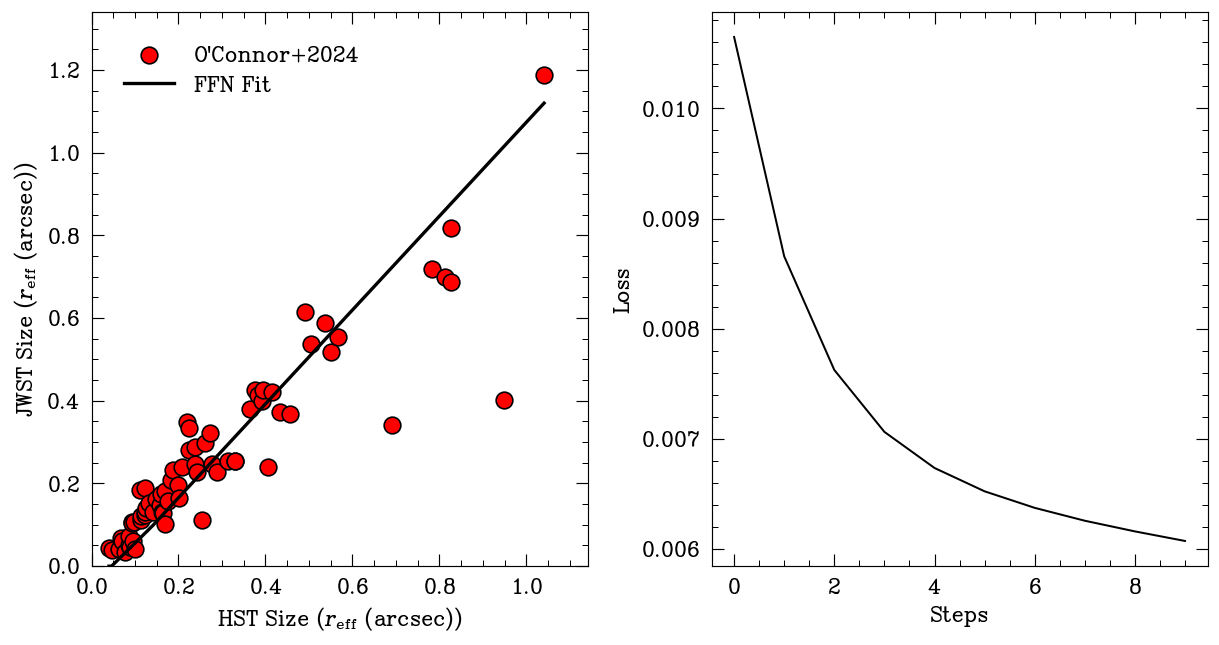

In [104]:
# x_equal = np.linspace(-0.1,1.1)
# y_equal = x_equal

np.random.seed(42)

## Using the FFN
x = np.array(hst_size)
y = np.array(jwst_size)

# sort arrays so x is always increasing
sorted_indices = np.argsort(x)
x = x[sorted_indices]
y = y[sorted_indices]

# reshape x and y to correct format
x = x.reshape(1, -1)
y = y.reshape(1, -1)

# run the neural network
nn = FFN_line_fit(input_size=1, hidden_size=5, output_size=1, learning_rate=0.1)
nn.train(x, y, steps=10)

# Make predictions
y_pred = nn.forward_pass(x)

# Plotting the results
fig, (ax1,ax2) = plt.subplots(1,2, figsize = (12,6))

plt.subplots_adjust(wspace = 0.25)


ax1.scatter(x.flatten(), y.flatten(), s=100, edgecolor='black', color='red', label="O'Connor+2024", zorder=2)
ax1.plot(x.flatten(), y_pred.flatten(), color='black', linewidth=2, label='FFN Fit', zorder=3)
# ax1.plot(x_equal,y_equal, linestyle='dashed', color='black', zorder=1)

ax1.set_xlabel(r'HST Size ($r_\mathrm{eff}$ (arcsec))')
ax1.set_ylabel(r'JWST Size ($r_\mathrm{eff}$ (arcsec))')

ax1.legend(loc='best')

ax1.set_xlim(0, np.max(hst_size)+0.1)
ax1.set_ylim(0, np.max(hst_size)+0.3)

ax2.plot(nn.steps_list, nn.loss_list)

ax2.set_xlabel(r'Steps')
ax2.set_ylabel(r'Loss')

plt.savefig(os.path.join(fig_dir,'jwst_hst_size_fit_loss.pdf'))

#### Now plot the loss for only 10 steps

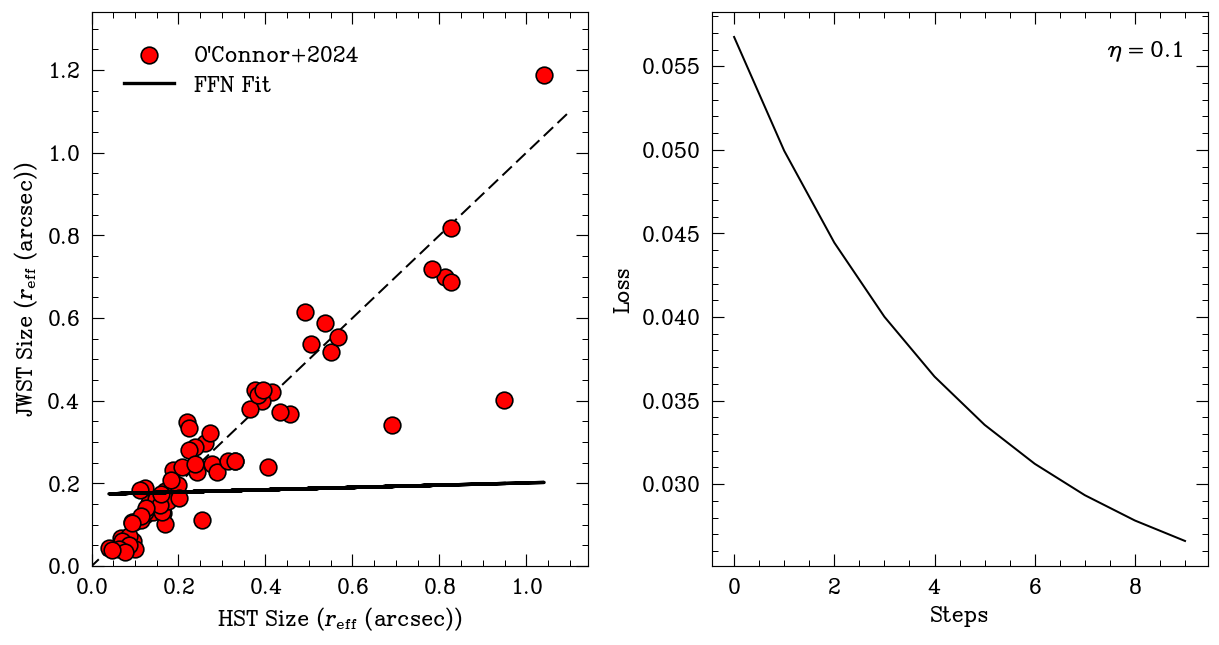

In [84]:
## Using the FFN
x = np.array(hst_size)
y = np.array(jwst_size)

# reshape x and y to correct format
x = x.reshape(1, -1)
y = y.reshape(1, -1)

# run the neural network
nn = FFN_line_fit(input_size=1, hidden_size=5, output_size=1, learning_rate=0.1)
nn.train(x, y, steps=10)

# make predictions
y_pred = nn.forward_pass(x)

# Plotting the results
fig, (ax1,ax2) = plt.subplots(1,2, figsize = (12,6))

plt.subplots_adjust(wspace = 0.25)

ax1.scatter(x.flatten(), y.flatten(), s=100, edgecolor='black', color='red', label="O'Connor+2024", zorder=2)
ax1.plot(x.flatten(), y_pred.flatten(), color='black', linewidth=2, label='FFN Fit', zorder=3)
ax1.plot(x_equal,y_equal, linestyle='dashed', color='black', zorder=1)

ax1.set_xlabel(r'HST Size ($r_\mathrm{eff}$ (arcsec))')
ax1.set_ylabel(r'JWST Size ($r_\mathrm{eff}$ (arcsec))')

ax1.legend(loc='best')

ax1.set_xlim(0, np.max(hst_size)+0.1)
ax1.set_ylim(0, np.max(hst_size)+0.3)

ax2.plot(nn.steps_list, nn.loss_list)

ax2.text(0.95, 0.95, f'$\eta = 0.1$', 
         transform=ax2.transAxes,  # Use axes coordinates (0 to 1)
         ha='right', va='top',      # Align text to the right and top
         fontsize=16, color='black')  # Customize font size and color

ax2.set_xlabel(r'Steps')
ax2.set_ylabel(r'Loss')

plt.savefig(os.path.join(fig_dir, 'jwst_hst_ffn_eta_01.pdf'))

#### Extracting the data to latex tables for the report

For the sake of the report, we will report the weights, gradients, outputs and losses for 10 steps for only 1 $x$ input and output with only 5 neurons.

0.949 0.402109523


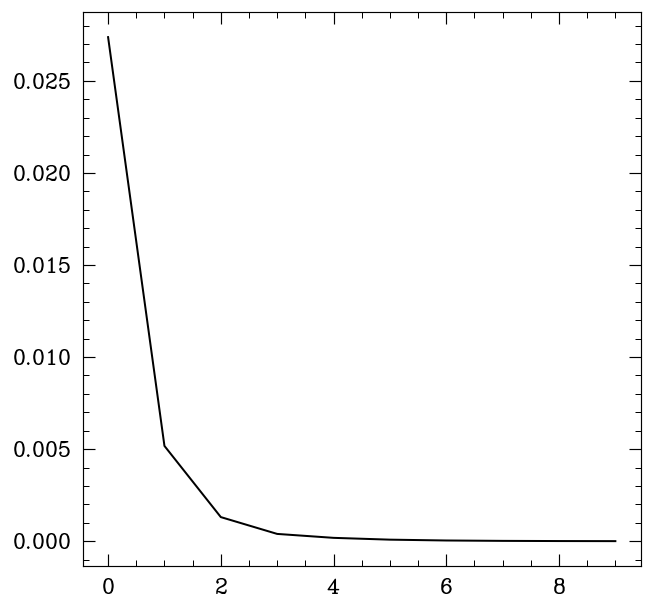

In [268]:
np.random.seed(6969696)

## Using the FFN
x = np.array(hst_size[0])
y = np.array(jwst_size[0])

print(x,y)

# reshape x and y to correct format
x = x.reshape(1, -1)
y = y.reshape(1, -1)

# run the neural network
nn = FFN_line_fit(input_size=1, hidden_size=5, output_size=1, learning_rate=0.1)
nn.train(x, y, steps=10)

plt.plot(nn.steps_list, nn.loss_list)

In [132]:
def generate_latex_tables(history):
    # Extracting the relevant data
    steps = list(range(len(history['weights_W0'])))
    
    # Formatting the first entry of weights and biases to four decimal places
    W0s = [np.array2string(np.array(history['weights_W0'][step]), precision=6, suppress_small=True, separator=',')[1:-1].replace('[','').replace(']','') for step in steps]
    B0s = [np.array2string(np.array(history['biases_B0'][step]), precision=6, suppress_small=True, separator=',')[1:-1].replace('[','').replace(']','') for step in steps]
    W1s = [np.array2string(np.array(history['weights_W1'][step]), precision=6, suppress_small=True, separator=',')[1:-1].replace('[','').replace(']','') for step in steps]
    B1s = [np.array2string(np.array(history['biases_B1'][step]), precision=6, suppress_small=True, separator=',')[1:-1].replace('[','').replace(']','') for step in steps]

    # Only keep first entries of gradients for weights and biases
    dLdW0s = [np.array2string(np.array(history['dLdW0'][step]), precision=6, suppress_small=True, separator=',')[1:-1].replace('[','').replace(']','') for step in steps]
    dLdB0s = [np.array2string(np.array(history['dLdB0'][step]), precision=6, suppress_small=True, separator=',')[1:-1].replace('[','').replace(']','') for step in steps]
    dLdW1s = [np.array2string(np.array(history['dLdW1'][step]), precision=6, suppress_small=True, separator=',')[1:-1].replace('[','').replace(']','') for step in steps]
    dLdB1s = [np.array2string(np.array(history['dLdB1'][step]), precision=6, suppress_small=True, separator=',')[1:-1].replace('[','').replace(']','') for step in steps]
    
    A0s = [np.array2string(np.array(history['A0'][step]), precision=6, suppress_small=True, separator=',')[1:-1].replace('[','').replace(']','') for step in steps]
    Y1s = [np.array2string(np.array(history['Y1'][step]), precision=6, suppress_small=True, separator=',')[1:-1].replace('[','').replace(']','') for step in steps]
    losses = [f"{loss:.4f}" for loss in history['loss']]

    # Building the LaTeX tables
    weights_biases_table = r"""\begin{sidewaystable}[t!]
\centering
\begin{tabular}{|c|c|c|c|c|}
\hline
Step & $\mathbf{W_0} = w_k^{(0)} = (w_1, w_2, w_3, w_4 ,w_5)$ & $\mathbf{B_0} = b_k^{(0)} = (w_1, w_2, w_3, w_4, w_5)$ & $\mathbf{W_1} = w_j^{(1)} = (w_1, w_2, w_3, w_4, w_5)$ & $b^{(1)}$ \\
\hline
"""
    
    for step in steps:
        weights_biases_table += f"{step} & {W0s[step]} & {B0s[step]} & {W1s[step]} & {B1s[step]} \\\ \n"

    weights_biases_table += r"""\hline
\end{tabular}
\caption{Weights and biases after each training step.}
\label{tab:weights_biases}
\end{sidewaystable}
"""

    gradients_table = r"""\begin{sidewaystable}
\centering
\begin{tabular}{|c|c|c|c|c|}
\hline
Step & $dL/d\mathbf{W_0}$ & $dL/d\mathbf{B_0}$ & $dL/d\mathbf{W_1}$ & $dL/dB_1$ \\
\hline
"""
    
    for step in steps:
        gradients_table += f"{step} & {dLdW0s[step]} & {dLdB0s[step]} & {dLdW1s[step]} & {dLdB1s[step]} \\\ \n"

    gradients_table += r"""\hline
\end{tabular}
\caption{Gradients after each training step.}
\label{tab:gradients}
\end{sidewaystable}
"""

    outputs_losses_table = r"""\begin{sidewaystable}
\centering
\begin{tabular}{|c|c|c|}
\hline
Step & $\mathbf{A_0} = a_k^{(0)} = (a_1, a_2, a_3, a_4, a_5)$ & $y^{(1)}$ & Loss \\
\hline
"""
    
    for step in steps:
        outputs_losses_table += f"{step} & {A0s[step]} & {Y1s[step]} & {losses[step]} \\\ \n"

    outputs_losses_table += r"""\hline
\end{tabular}
\caption{Outputs and losses after each training step.}
\label{tab:outputs_losses}
\end{sidewaystable}
"""

    return weights_biases_table, gradients_table, outputs_losses_table

# Usage example:
weights_biases_latex = generate_latex_tables(nn.history)
for table in weights_biases_latex:
    print(table)


\begin{sidewaystable}[t!]
\centering
\begin{tabular}{|c|c|c|c|c|}
\hline
Step & $\mathbf{W_0} = w_k^{(0)} = (w_1, w_2, w_3, w_4 ,w_5)$ & $\mathbf{B_0} = b_k^{(0)} = (w_1, w_2, w_3, w_4, w_5)$ & $\mathbf{W_1} = w_j^{(1)} = (w_1, w_2, w_3, w_4, w_5)$ & $b^{(1)}$ \\
\hline
0 & 0.549227,0.714596,0.660197,0.279934,0.954865 & 0.,0.,0.,0.,0. & 0.737897,0.554354,0.611721,0.4196  ,0.247731 & 0. \\ 
1 & 0.473763,0.657903,0.597638,0.237022,0.92953  & -0.079519,-0.05974 ,-0.065922,-0.045218,-0.026697 & 0.681728,0.481273,0.544203,0.390972,0.150078 & -0.107765 \\ 
2 & 0.442348,0.635725,0.57256 ,0.219006,0.922614 & -0.112622,-0.083109,-0.092347,-0.064203,-0.033984 & 0.663758,0.453857,0.519865,0.382245,0.108541 & -0.156322 \\ 
3 & 0.425828,0.62443 ,0.559622,0.209492,0.919913 & -0.13003 ,-0.095012,-0.105981,-0.074227,-0.036831 & 0.655702,0.440215,0.508036,0.378478,0.08647  & -0.182548 \\ 
4 & 0.416524,0.618183,0.552413,0.204122,0.918686 & -0.139834,-0.101594,-0.113577,-0.079886,-0.038123 & 0.651604,0.4

## Question 5 

*Finally, increase your learning rate so that the loss does not decrease consistently. This demonstrates the importance of chosing an appropriate learning rate, and it ensures that your chosen problem and network are not overly simplistic. This step is worth the remaining $25\%$*. 

**Answer:**

0.949 0.402109523


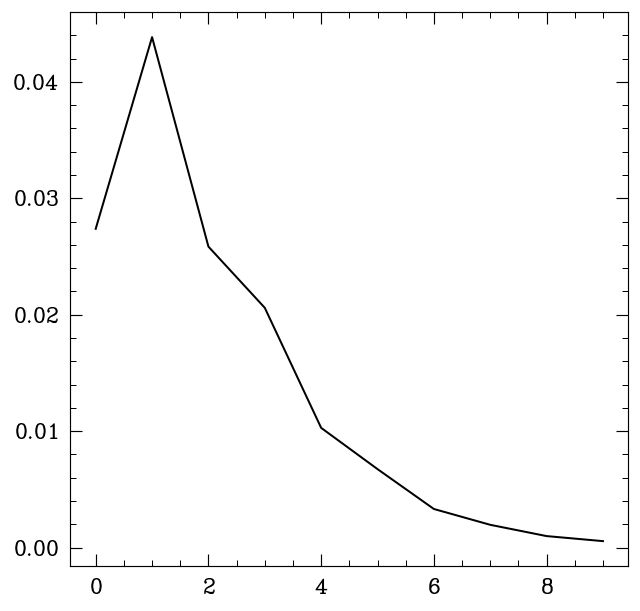

In [265]:
np.random.seed(6969696)

## Using the FFN
x = np.array(hst_size[0])
y = np.array(jwst_size[0])

print(x,y)

# reshape x and y to correct format
x = x.reshape(1, -1)
y = y.reshape(1, -1)

# run the neural network
nn = FFN_line_fit(input_size=1, hidden_size=5, output_size=1, learning_rate=0.6)
nn.train(x, y, steps=10)

plt.plot(nn.steps_list, nn.loss_list)

In [264]:
nn.history['Y1']

[array([[0.63609908]]),
 array([[0.10601222]]),
 array([[0.62946235]]),
 array([[0.19918973]]),
 array([[0.5454846]]),
 array([[0.2860418]]),
 array([[0.48348954]]),
 array([[0.3396325]]),
 array([[0.44645234]]),
 array([[0.36894175]])]